In [20]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2
import json
from pathlib import Path


In [21]:
# Setup paths
BASE_DIR = Path('..')
DATA_DIR = BASE_DIR / 'data' / 'raw'
PROCESSED_DIR = BASE_DIR / 'data' / 'processed'
AUGMENTED_DIR = BASE_DIR / 'data' / 'augmented'

In [22]:
# Create directories if not exist
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
AUGMENTED_DIR.mkdir(parents=True, exist_ok=True)

In [23]:
# %%
# Explore dataset structure
print("Dataset structure:")
for fruit in ['tomato', 'mango', 'banana']:
    fruit_path = DATA_DIR / fruit
    if fruit_path.exists():
        print(f"\n{fruit}:")
        for ripeness in ['unripe', 'ripe', 'overripe']:
            ripeness_path = fruit_path / ripeness
            if ripeness_path.exists():
                num_images = len(list(ripeness_path.glob('*.*')))
                print(f"  {ripeness}: {num_images} images")

Dataset structure:

tomato:
  unripe: 87 images
  ripe: 83 images
  overripe: 96 images

mango:
  unripe: 89 images
  ripe: 79 images
  overripe: 85 images

banana:
  unripe: 95 images
  ripe: 94 images
  overripe: 86 images


In [24]:
# %%
# Create dataset metadata
def create_dataset_metadata(data_dir):
    metadata = []
    classes = []
    
    for fruit in ['tomato', 'mango', 'banana']:
        for ripeness in ['unripe', 'ripe', 'overripe']:
            class_name = f"{fruit}_{ripeness}"
            classes.append(class_name)
            
            class_path = data_dir / fruit / ripeness
            if class_path.exists():
                for img_path in class_path.glob('*.*'):
                    if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']:
                        metadata.append({
                            'file_path': str(img_path),
                            'fruit': fruit,
                            'ripeness': ripeness,
                            'class': class_name,
                            'class_idx': len(classes) - 1
                        })
    
    return pd.DataFrame(metadata), classes


In [25]:
# %%
# Load metadata
df, classes = create_dataset_metadata(DATA_DIR)
print(f"Total images: {len(df)}")
print(f"Classes: {classes}")

Total images: 794
Classes: ['tomato_unripe', 'tomato_ripe', 'tomato_overripe', 'mango_unripe', 'mango_ripe', 'mango_overripe', 'banana_unripe', 'banana_ripe', 'banana_overripe']


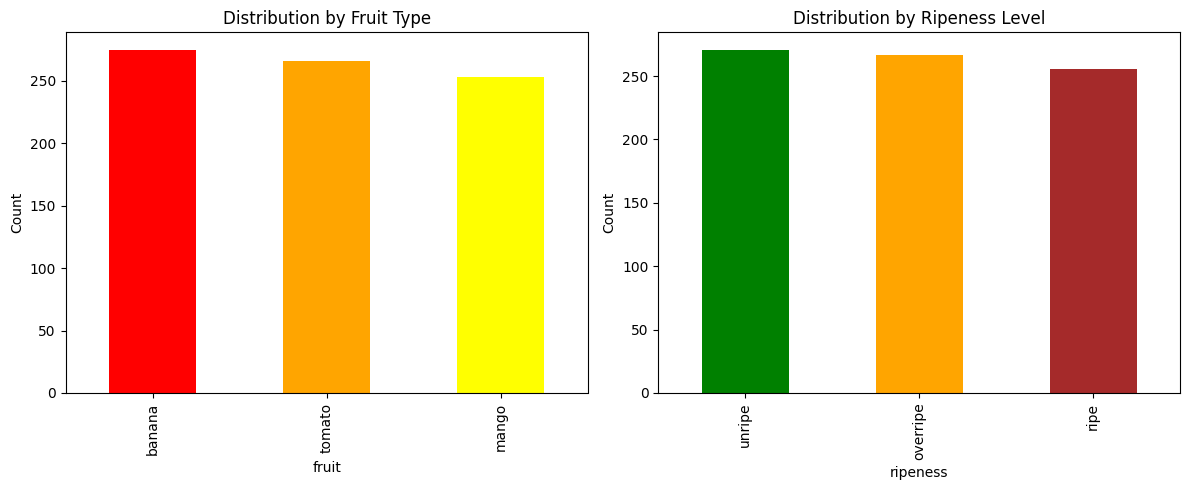

In [26]:
# Display dataset distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df['fruit'].value_counts().plot(kind='bar', color=['red', 'orange', 'yellow'])
plt.title('Distribution by Fruit Type')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
df['ripeness'].value_counts().plot(kind='bar', color=['green', 'orange', 'brown'])
plt.title('Distribution by Ripeness Level')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


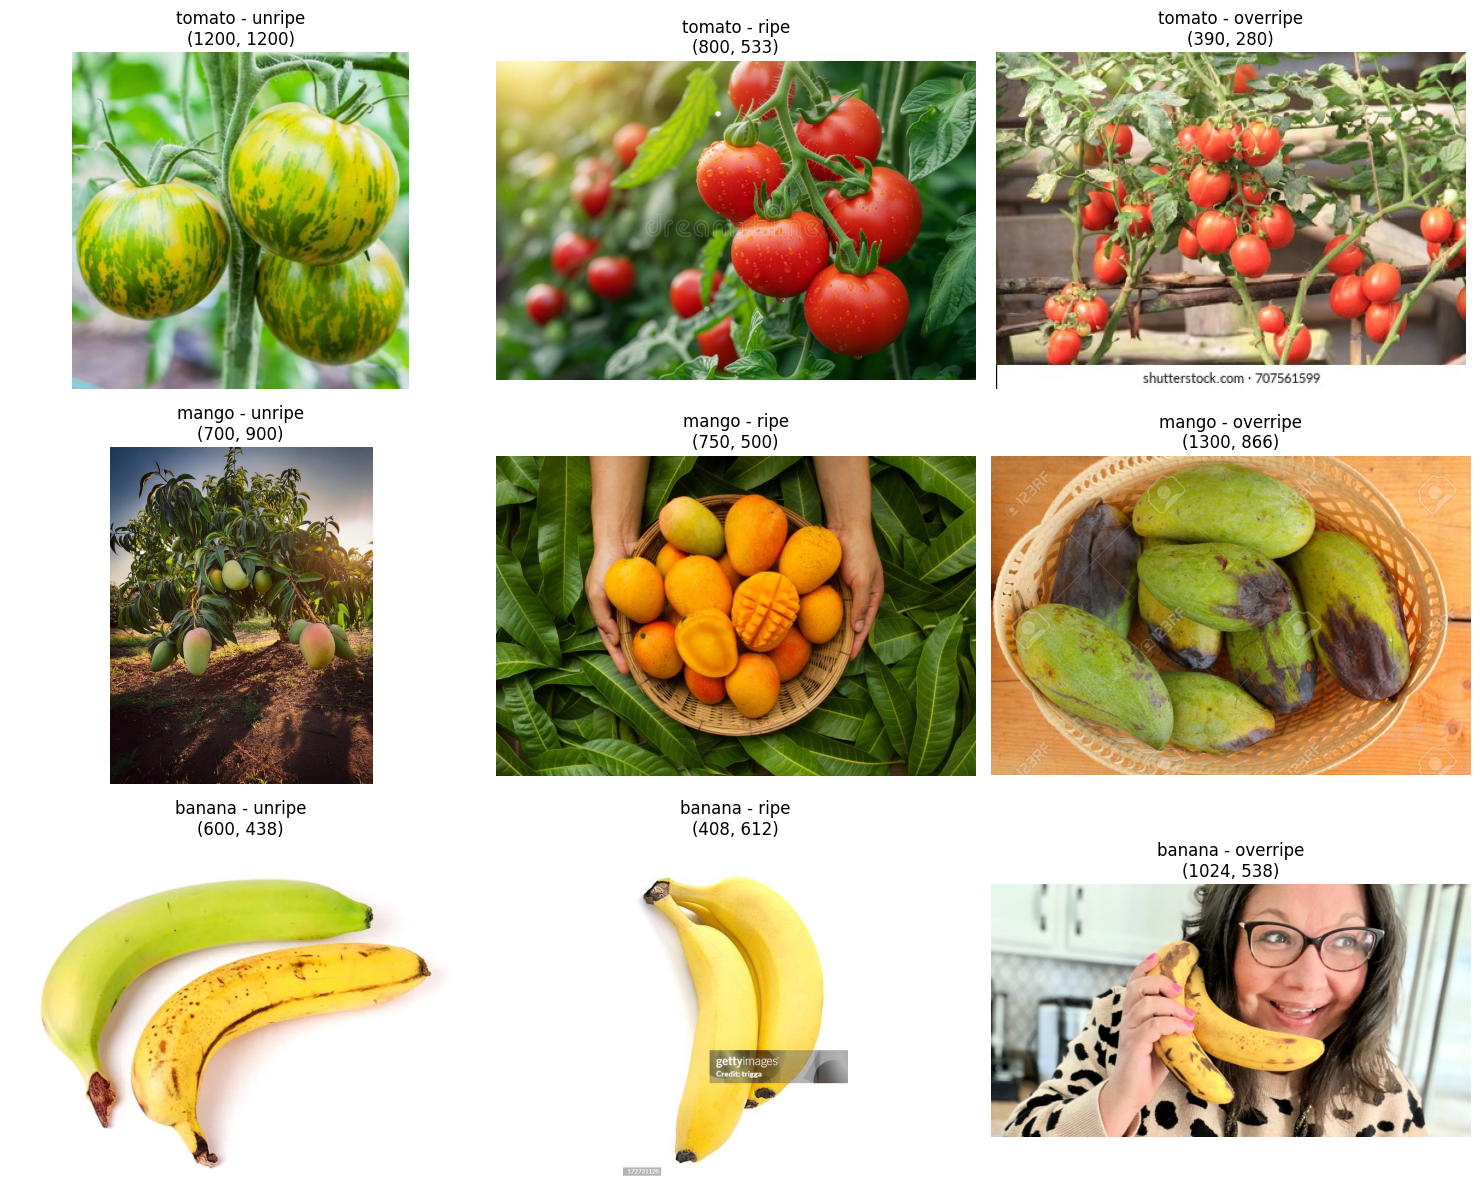

In [27]:
# %%
# Display sample images
def display_sample_images(df, num_samples=3):
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    
    for i, fruit in enumerate(['tomato', 'mango', 'banana']):
        for j, ripeness in enumerate(['unripe', 'ripe', 'overripe']):
            class_df = df[(df['fruit'] == fruit) & (df['ripeness'] == ripeness)]
            
            if len(class_df) > 0:
                sample = class_df.sample(1).iloc[0]
                img = Image.open(sample['file_path'])
                
                axes[i, j].imshow(img)
                axes[i, j].set_title(f"{fruit} - {ripeness}\n{img.size}")
                axes[i, j].axis('off')
            else:
                axes[i, j].set_title(f"No {fruit} - {ripeness}")
                axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

display_sample_images(df)


In [28]:
# %%
# Train-validation-test split
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, 
                                    stratify=df['class'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42,
                                  stratify=temp_df['class'])

print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")

Training set: 555 images
Validation set: 119 images
Test set: 120 images


In [29]:
# %%
# Save split information
split_info = {
    'train_files': train_df['file_path'].tolist(),
    'val_files': val_df['file_path'].tolist(),
    'test_files': test_df['file_path'].tolist(),
    'classes': classes,
    'class_mapping': {cls: idx for idx, cls in enumerate(classes)}
}

with open(PROCESSED_DIR / 'data_splits.json', 'w') as f:
    json.dump(split_info, f, indent=2)

In [30]:
# Save dataframes
train_df.to_csv(PROCESSED_DIR / 'train_metadata.csv', index=False)
val_df.to_csv(PROCESSED_DIR / 'val_metadata.csv', index=False)
test_df.to_csv(PROCESSED_DIR / 'test_metadata.csv', index=False)

print("Data splits saved successfully!")

Data splits saved successfully!


In [31]:
# %%
# Basic image preprocessing analysis
def analyze_images(df):
    sizes = []
    for file_path in df['file_path']:
        try:
            with Image.open(file_path) as img:
                sizes.append(img.size)
        except:
            sizes.append((0, 0))
    
    sizes = np.array(sizes)
    return {
        'width_stats': {
            'min': np.min(sizes[:, 0]),
            'max': np.max(sizes[:, 0]),
            'mean': np.mean(sizes[:, 0]),
            'median': np.median(sizes[:, 0])
        },
        'height_stats': {
            'min': np.min(sizes[:, 1]),
            'max': np.max(sizes[:, 1]),
            'mean': np.mean(sizes[:, 1]),
            'median': np.median(sizes[:, 1])
        }
    }

In [32]:
# %%
# Analyze image dimensions
stats = analyze_images(df)
print("Image dimensions analysis:")
print(f"Width - Min: {stats['width_stats']['min']}, Max: {stats['width_stats']['max']}, Mean: {stats['width_stats']['mean']:.1f}")
print(f"Height - Min: {stats['height_stats']['min']}, Max: {stats['height_stats']['max']}, Mean: {stats['height_stats']['mean']:.1f}")


Image dimensions analysis:
Width - Min: 0, Max: 5664, Mean: 831.6
Height - Min: 0, Max: 6000, Mean: 701.2


In [33]:
# %%
# Create preprocessing configuration
preprocessing_config = {
    'target_size': [224, 224],  # Standard size for most CNN models
    'normalization': {
        'mean': [0.485, 0.456, 0.406],  # ImageNet stats
        'std': [0.229, 0.224, 0.225]
    },
    'augmentation': {
        'rotation_range': 20,
        'width_shift_range': 0.2,
        'height_shift_range': 0.2,
        'horizontal_flip': True,
        'zoom_range': 0.2,
        'brightness_range': [0.8, 1.2]
    }
}

with open(PROCESSED_DIR / 'preprocessing_config.json', 'w') as f:
    json.dump(preprocessing_config, f, indent=2)

print("Data preparation completed!")
print(f"Total images: {len(df)}")
print(f"Classes: {len(classes)}")
print(f"Training: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

Data preparation completed!
Total images: 794
Classes: 9
Training: 555, Validation: 119, Test: 120


FINISH